In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.signal import medfilt, find_peaks, find_peaks_cwt, lfilter, savgol_filter
import numpy as np
import tifffile as ti
from skimage.filters.thresholding import threshold_li, threshold_yen
import cv2
from skimage.util import img_as_uint
from scipy import ndimage
matplotlib.rcParams['figure.figsize'] = [15, 12]
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import re

In [3]:
def list_images_of_point(images, point):
    """
    Given a list of images and a point, returns a list of image names that contain the point in their file names.
    
    Parameters:
        images (list): List of image file names.
        point (str): Point to search for in image file names.
    
    Returns:
        list: List of image names that contain the point in their file names.
    """
    
    # Initialize empty list to store image names
    image_names = []
    
    # Iterate through list of images
    for image in images:
        # Check if point is in the image file name
        if point in os.path.basename(image):
            # If point is found, append image name to list
            image_names.append(image)
    
    # Return list of image names
    return image_names

def get_square_bbox(mask, expand=10):
	# Creation of the bounding box.
	y, x = np.where(mask != 0)

	ymin = int(np.min(y))
	ymax = int(np.max(y))
	xmin = int(np.min(x))
	xmax = int(np.max(x))

	w = ymax-ymin
	h = xmax-xmin

	ymin -= expand//2
	xmin -= expand//2

	if ymin < 0:
		ymin = 0
	if xmin < 0:
		xmin = 0

	w += expand
	h += expand

	square_dim = max(w, h)

	# For some reason, the next steps only work with a image whose dimensions can be divided by four.
	while (square_dim % 4 != 0):
		square_dim += 1

	# If the bounding box would come out of the image, moove the bounding box's origin (xmin, ymin).
	if (xmin + square_dim) > mask.shape[1]:
		xmin = (xmin - ((xmin + square_dim) - mask.shape[1]))

	if (ymin + square_dim) > mask.shape[0]:
		ymin = (ymin - ((ymin + square_dim) - mask.shape[0]))

	return [ymin, xmin, square_dim]

def get_bbox(mask, expand=10):
	# Creation of the bounding box.
	y, x = np.where(mask != 0)

	ymin = int(np.min(y))
	ymax = int(np.max(y))
	xmin = int(np.min(x))
	xmax = int(np.max(x))

	w = ymax-ymin
	h = xmax-xmin

	ymin -= expand//2
	xmin -= expand//2

	if ymin < 0:
		ymin = 0
	if xmin < 0:
		xmin = 0

	w += expand
	h += expand


	return [ymin, xmin, w, h]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [4]:
def get_xaxis(point, csv_path):
    dataframe = pd.read_csv(csv_path)

    dataframe = dataframe[dataframe['Point'] == point]

    dataframe.drop('Point', inplace=True, axis=1)

    mean_GFP_intensity = dataframe.to_numpy().squeeze()
    if csv_path == "./nuclei_GFP_intensity.csv":
        x_axis = (np.array((range(len(mean_GFP_intensity))))*10)/60
        mean_GFP_intensity = mean_GFP_intensity[100:]
        x_axis = x_axis[100:]
    return x_axis

def plot_gfp_intensity_for_point(point, x_axis, csv_path, linewidth = 3, linestyle='solid', alpha=1., color = None):
    dataframe = pd.read_csv(csv_path)

    dataframe = dataframe[dataframe['Point'] == point]

    dataframe.drop('Point', inplace=True, axis=1)

    mean_GFP_intensity = dataframe.to_numpy().squeeze()
    if csv_path == "./nuclei_GFP_intensity.csv":
        mean_GFP_intensity = mean_GFP_intensity[100:]

    nans, x= nan_helper(mean_GFP_intensity)
    mean_GFP_intensity[nans]= np.interp(x(nans), x(~nans), mean_GFP_intensity[~nans])

    if color :
        plt.plot(x_axis, mean_GFP_intensity, linestyle = linestyle, linewidth = linewidth, alpha=alpha, color=color)
    else:
        plt.plot(x_axis, mean_GFP_intensity, linestyle = linestyle, linewidth = linewidth, alpha=alpha)

def extract_split(s):
    """Extract the last occurence of "split_x-y" where x and y are two numbers in a string """
    pattern = r'split_\d+-\d+'
    matches = re.findall(pattern, s)
    if matches:
        return matches[-1]
    else:
        return None

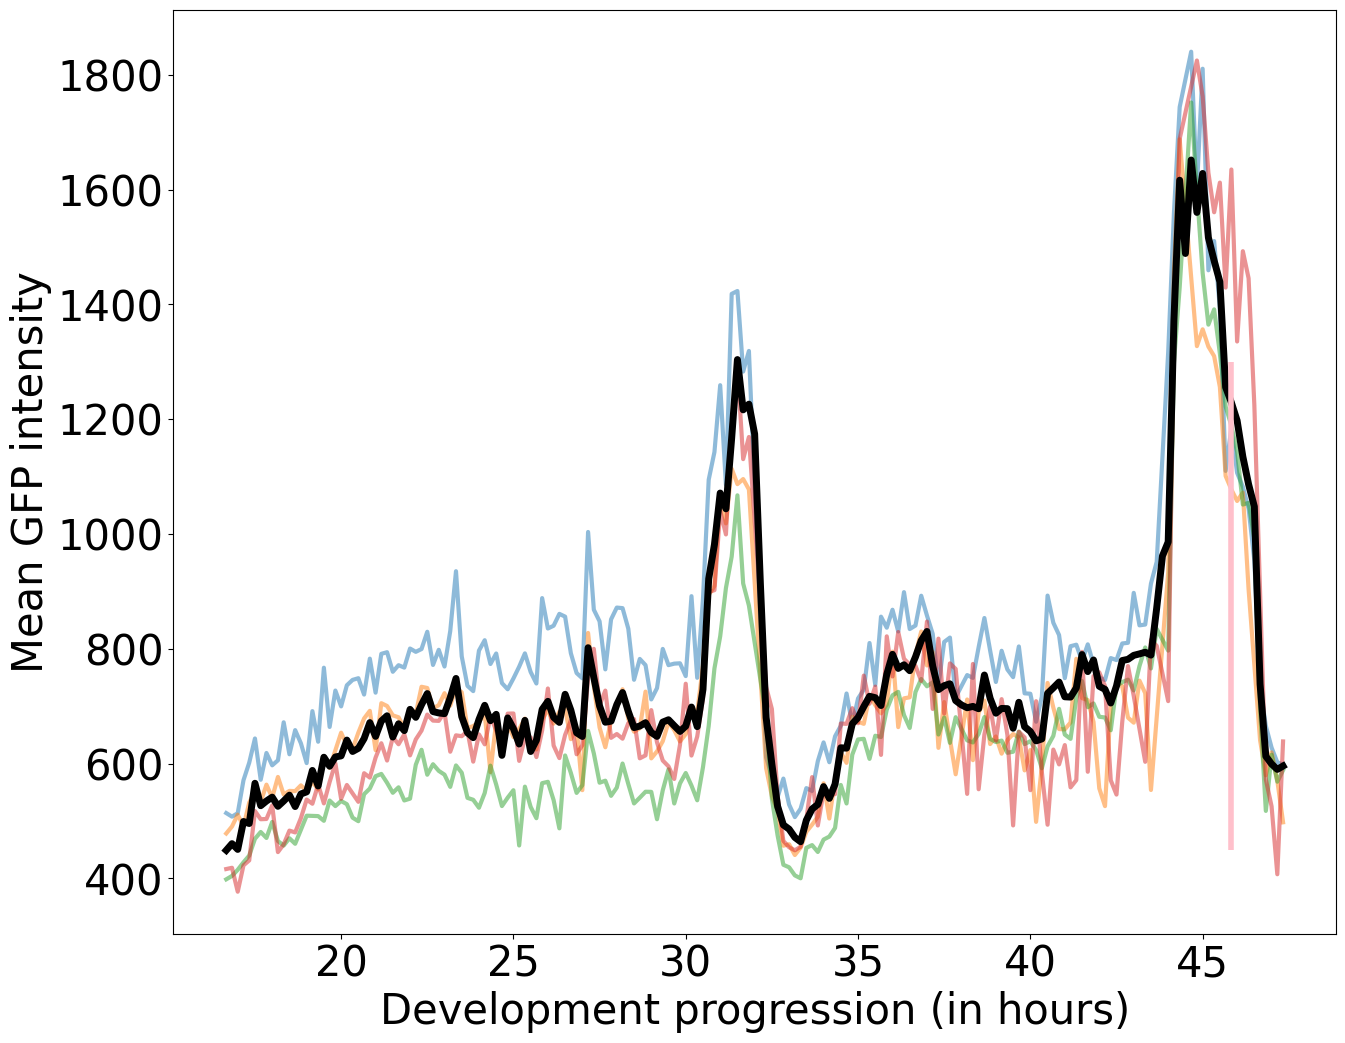

In [5]:
csv_path_all_nuclei = "./nuclei_GFP_intensity.csv"

unique_splits = np.unique([split for split in [extract_split(x) for x in os.listdir('./')] if split is not None])

point = "Point0017"

x_axis = get_xaxis(point, csv_path_all_nuclei)
for split in unique_splits[1:]:
    csv_path = f'./nuclei_GFP_intensity_WBT281_{split}.csv'
    plot_gfp_intensity_for_point(point, x_axis, csv_path, linestyle = 'solid', alpha=0.5)

plot_gfp_intensity_for_point(point, x_axis, csv_path_all_nuclei, linestyle='solid', linewidth=5, color='black')

plt.vlines((275*10)/60, 450, 1300, linewidth = 4, color="pink", linestyles="solid")
# legend = list(unique_splits[1:])
# legend.append('all_nuclei')
# print(legend)
# plt.legend(legend)
plt.ylabel('Mean GFP intensity')
plt.xlabel('Development progression (in hours)')
# plot_gfp_intensity_for_point(csv_path_second_third)
# plot_gfp_intensity_for_point(csv_path_last_third)
plt.savefig(f'./plot_split_nuclei_{point}.pdf', bbox_inches='tight')
plt.show()